# Написанный ручками класс линейной регрессии + тест функций активаций + тест различных ядер(фильтров) + LeNet

In [1]:
!pip install -q catalyst

In [113]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

from catalyst import utils

sns.set(style="darkgrid", font_scale=1.4)
%matplotlib inline

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$.


In [114]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.Tensor(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term 
        return x

### Датасет и его генерация

In [115]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

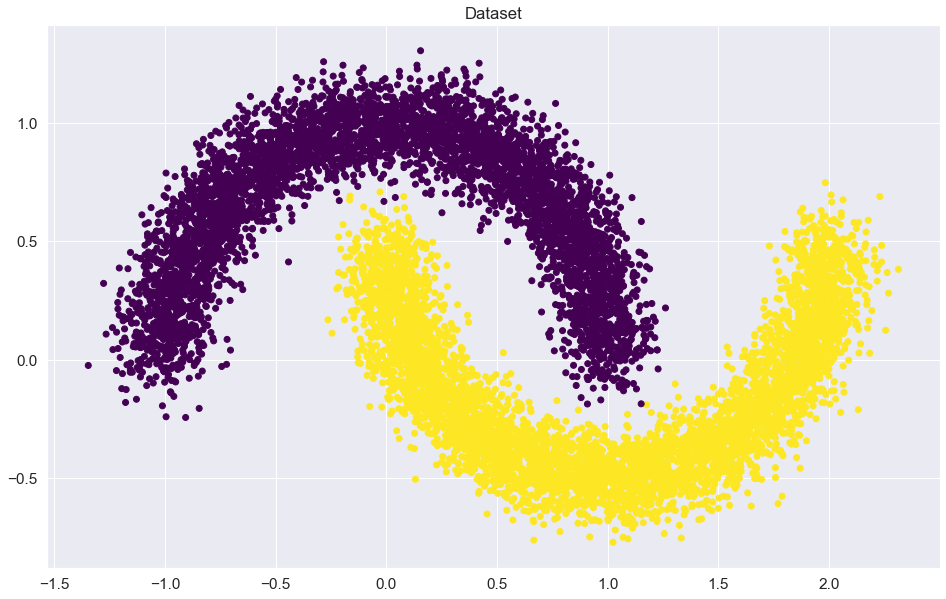

In [116]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

In [117]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [118]:
X_train_t = torch.tensor(np.float32(X_train)) 
y_train_t = torch.tensor(np.float32(y_train)) 
X_val_t = torch.tensor(np.float32(X_val)) 
y_val_t = torch.tensor(np.float32(y_val)) 
X_train_t.dtype

torch.float32

In [119]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [120]:
utils.set_global_seed(42)
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)


In [34]:
pip install torch-summary

Note: you may need to restart the kernel to use updated packages.


In [121]:
from torchsummary import summary

summary(linear_regression, (X_train.shape[1], ))

Layer (type:depth-idx)                   Output Shape              Param #
└─LinearRegression: 0-1                  [-1]                      3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Layer (type:depth-idx)                   Output Shape              Param #
└─LinearRegression: 0-1                  [-1]                      3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [122]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    utils.set_global_seed(42 + epoch)
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression.forward(X_batch) 
        loss = loss_function(outp, y_batch) 
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp) 
        preds = (probabilities>0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum()/y_batch.size(0)
        if it % 500000 == 0:
            print(f"Iteration: {it + epoch*len(train_dataset)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch*len(train_dataset)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.6484375
Iteration: 7500
Batch accuracy: 0.734375
Iteration: 15000
Batch accuracy: 0.78125
Iteration: 22500
Batch accuracy: 0.7890625
Iteration: 30000
Batch accuracy: 0.8046875
Iteration: 37500
Batch accuracy: 0.8046875
Iteration: 45000
Batch accuracy: 0.8046875
Iteration: 52500
Batch accuracy: 0.8046875
Iteration: 60000
Batch accuracy: 0.8203125
Iteration: 67500
Batch accuracy: 0.8203125
Iteration: 75000
Batch accuracy: 0.8203125
Iteration: 82500
Batch accuracy: 0.8203125
Iteration: 90000
Batch accuracy: 0.8203125

Iteration: 90051.Convergence. Stopping iterations.


### Визуализируем результаты

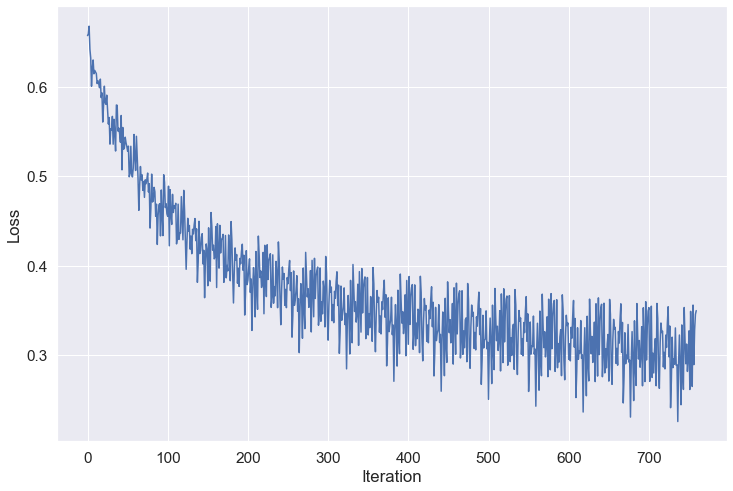

In [123]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

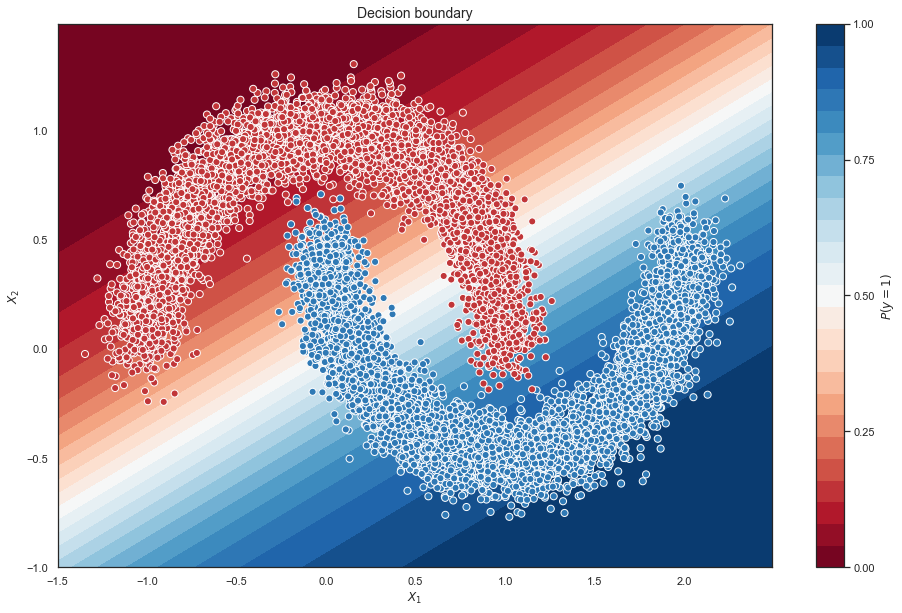

In [124]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [125]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

In [126]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val_t, predict(val_dataloader, linear_regression))

0.862

### MNIST

In [127]:
import os
from catalyst.contrib.datasets import MNIST

train_dataset = MNIST(root=os.getcwd(), train=True, download=True)
val_dataset = MNIST(root=os.getcwd(), train=False)
train_dataloader = DataLoader(train_dataset, batch_size = 128, drop_last = True) # YOUR CODE GOES HERE
valid_dataloader = DataLoader(val_dataset, batch_size = 128, drop_last = True) # YOUR CODE GOES HERE

In [128]:
class Identical(nn.Module):
    def forward(self, x):
        return x

class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.size(0)
        return x.view(batch_size, -1)

In [130]:
activation = nn.ReLU

model = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [131]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [132]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (посерьёзнее, чем было)


In [133]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42 + epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch.float())
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch.float())
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum()
            all =  len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9063668536324786
Loader: valid. Accuracy: 0.9117158882783882
Epoch: 2
Loader: train. Accuracy: 0.9565304487179487
Loader: valid. Accuracy: 0.9548563415750916
Epoch: 3
Loader: train. Accuracy: 0.9672809829059829
Loader: valid. Accuracy: 0.9653731684981685
Epoch: 4
Loader: train. Accuracy: 0.9727230235042735
Loader: valid. Accuracy: 0.9692651098901099
Epoch: 5
Loader: train. Accuracy: 0.9768796741452992
Loader: valid. Accuracy: 0.973529075091575
Epoch: 6
Loader: train. Accuracy: 0.9753271901709402
Loader: valid. Accuracy: 0.9733144459706959
Epoch: 7
Loader: train. Accuracy: 0.9805188301282052
Loader: valid. Accuracy: 0.97882326007326
Epoch: 8
Loader: train. Accuracy: 0.9817708333333334
Loader: valid. Accuracy: 0.979667467948718
Epoch: 9
Loader: train. Accuracy: 0.9806857638888888
Loader: valid. Accuracy: 0.9777787316849816
Epoch: 10
Loader: train. Accuracy: 0.9818709935897436
Loader: valid. Accuracy: 0.9800108745421245


In [82]:
plain_accuracy = accuracy["valid"]

In [134]:
relu_accuracy = accuracy["valid"]

In [78]:
leaky_relu_accuracy = accuracy["valid"]

In [68]:
elu_accuracy = accuracy["valid"]

### Accuracy

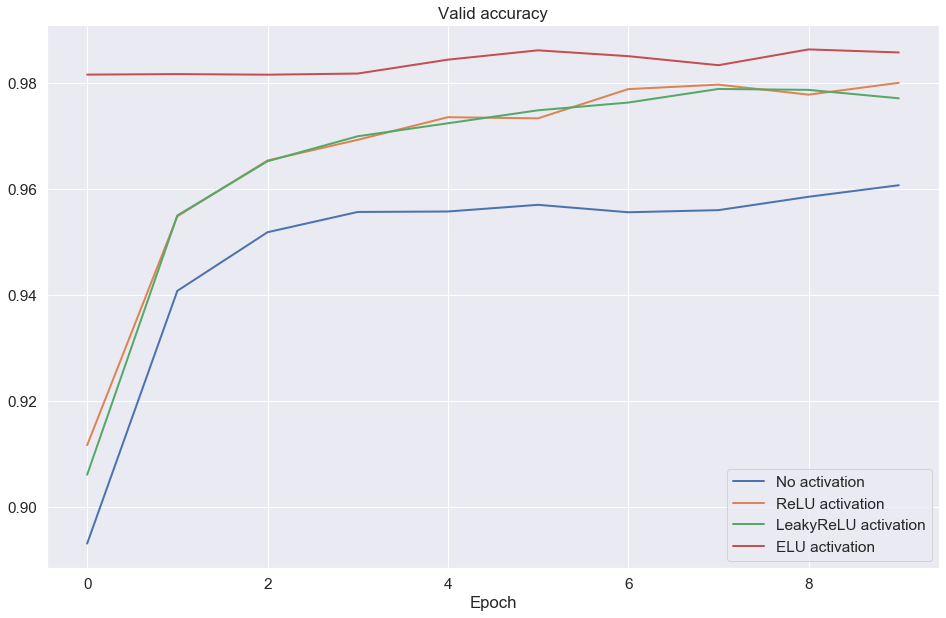

In [135]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

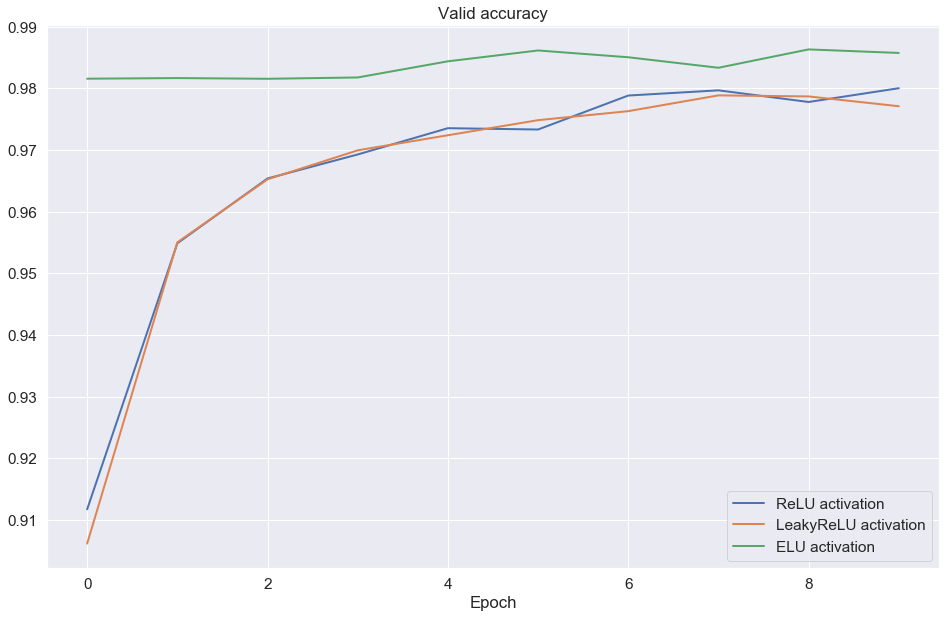

In [136]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

## Сверточные слои

### Ядра

In [137]:
import wget
url = 'https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg'
filename = wget.download(url)

100% [..............................................................................] 49337 / 49337

In [ ]:
pip install opencv-python

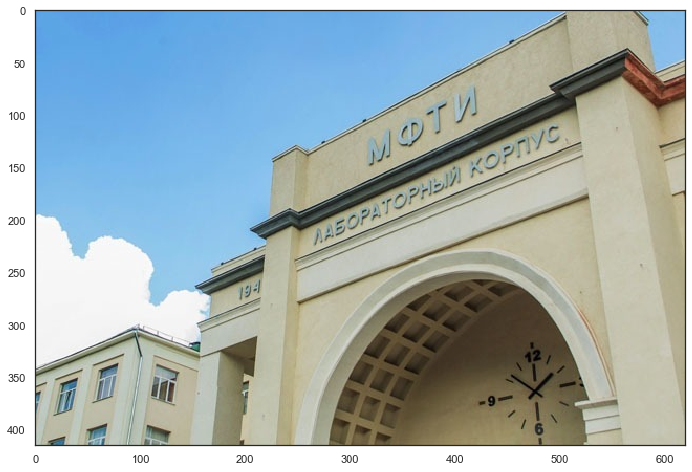

In [138]:
import cv2
sns.set(style="white")
img = cv2.imread(filename)
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Я пробовал посмотреть как различные свертки влияют на фото. Привожу ниже некоторые из них:

1)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
2)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
3)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
4)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
5)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
6)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

In [147]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  
img_t = nn.ReflectionPad2d(1)(img_t)  

result = F.conv2d(img_t, kernel)[0]  #

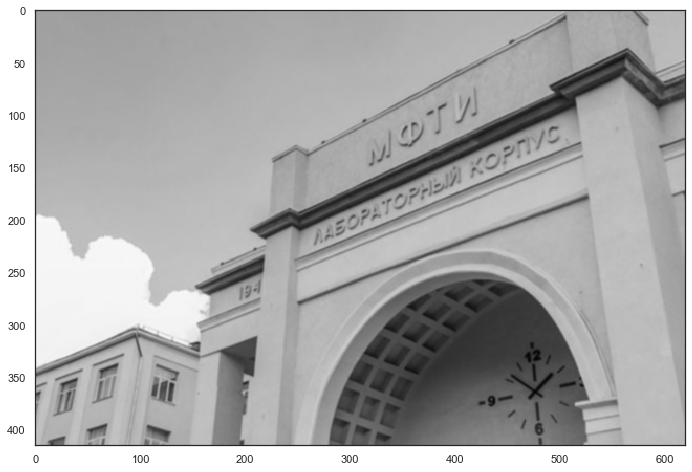

In [148]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

### LeNet


In [149]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [150]:
model = LeNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [152]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42+epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch.type(torch.float32).unsqueeze(1))
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch.type(torch.float32).unsqueeze(1))
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum()
            all =  len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

C:\Users\misha\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1
Loader: train. Accuracy: 0.9384014423076923
Loader: valid. Accuracy: 0.9434523809523809
Epoch: 2
Loader: train. Accuracy: 0.9800514155982906
Loader: valid. Accuracy: 0.9806690705128205
Epoch: 3
Loader: train. Accuracy: 0.9861611912393162
Loader: valid. Accuracy: 0.9859632554945055
Epoch: 4
Loader: train. Accuracy: 0.9900006677350427
Loader: valid. Accuracy: 0.9890968406593407
Epoch: 5
Loader: train. Accuracy: 0.9906350160256411
Loader: valid. Accuracy: 0.9899124313186813
Epoch: 6
Loader: train. Accuracy: 0.9918202457264957
Loader: valid. Accuracy: 0.9907423305860806
Epoch: 7
Loader: train. Accuracy: 0.9929553952991453
Loader: valid. Accuracy: 0.9913576007326007
Epoch: 8
Loader: train. Accuracy: 0.9942073985042735
Loader: valid. Accuracy: 0.9928456959706959
Epoch: 9
Loader: train. Accuracy: 0.9933894230769231
Loader: valid. Accuracy: 0.9922018086080586
Epoch: 10
Loader: train. Accuracy: 0.9942741720085471
Loader: valid. Accuracy: 0.9931318681318682


In [153]:
lenet_accuracy = accuracy["valid"]

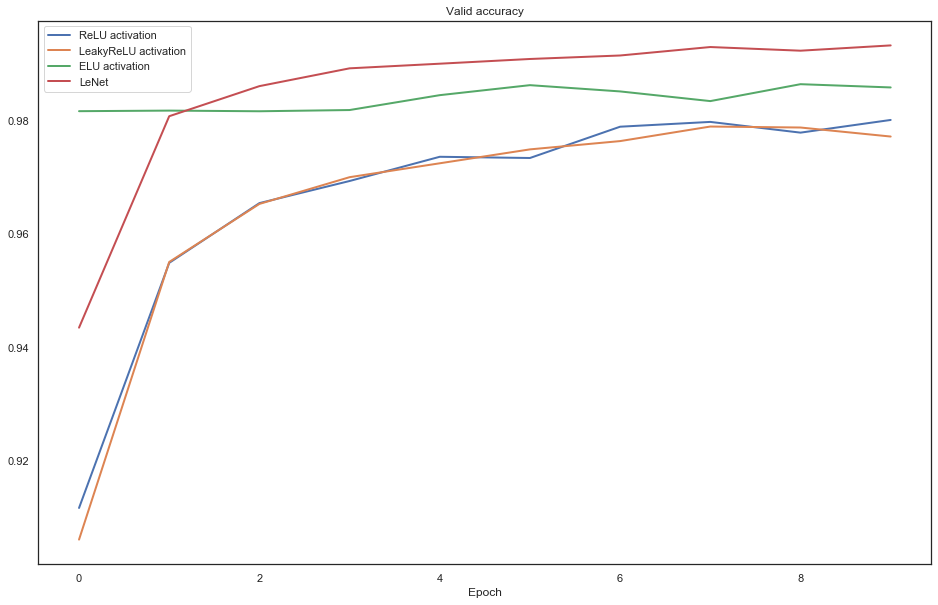

In [154]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()